In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hhs1516","key":"df77d1870d62b8065b1ea188acc8273c"}'}

In [ ]:
ls -1ha kaggle.json

kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c lish-moa

 75% 41.0M/54.8M [00:02<00:01, 12.3MB/s]
100% 54.8M/54.8M [00:02<00:00, 25.3MB/s]
  0% 0.00/535k [00:00<?, ?B/s]
100% 535k/535k [00:00<00:00, 75.9MB/s]
  0% 0.00/38.9k [00:00<?, ?B/s]
100% 38.9k/38.9k [00:00<00:00, 39.1MB/s]
  0% 0.00/233k [00:00<?, ?B/s]
100% 233k/233k [00:00<00:00, 76.8MB/s]
 55% 5.00M/9.16M [00:01<00:01, 3.71MB/s]
100% 9.16M/9.16M [00:01<00:00, 6.55MB/s]
  0% 0.00/257k [00:00<?, ?B/s]
100% 257k/257k [00:00<00:00, 84.8MB/s]


In [ ]:
!unzip -n /content/test_features.csv.zip
!unzip -n /content/train_features.csv.zip
!unzip -n /content/train_targets_nonscored.csv.zip
!unzip -n /content/train_targets_scored.csv.zip
!unzip -n /content/sample_submission.csv.zip

Archive:  /content/test_features.csv.zip
  inflating: test_features.csv       
Archive:  /content/train_features.csv.zip
  inflating: train_features.csv      
Archive:  /content/train_targets_nonscored.csv.zip
  inflating: train_targets_nonscored.csv  
Archive:  /content/train_targets_scored.csv.zip
  inflating: train_targets_scored.csv  
Archive:  /content/sample_submission.csv.zip
  inflating: sample_submission.csv   


In [ ]:
!pip install iterative-stratification

In [ ]:
files.upload() #pca prediction

Saving main_predictors.json to main_predictors.json


{'main_predictors.json': b'{"start_predictors":["g-0","g-7","g-8","g-10","g-13","g-17","g-20","g-22","g-24","g-26","g-28","g-29","g-30","g-31","g-32","g-34","g-35","g-36","g-37","g-38","g-39","g-41","g-46","g-48","g-50","g-51","g-52","g-55","g-58","g-59","g-61","g-62","g-63","g-65","g-66","g-67","g-68","g-70","g-72","g-74","g-75","g-79","g-83","g-84","g-85","g-86","g-90","g-91","g-94","g-95","g-96","g-97","g-98","g-100","g-102","g-105","g-106","g-112","g-113","g-114","g-116","g-121","g-123","g-126","g-128","g-131","g-132","g-134","g-135","g-138","g-139","g-140","g-142","g-144","g-145","g-146","g-147","g-148","g-152","g-155","g-157","g-158","g-160","g-163","g-164","g-165","g-170","g-173","g-174","g-175","g-177","g-178","g-181","g-183","g-185","g-186","g-189","g-192","g-194","g-195","g-196","g-197","g-199","g-201","g-202","g-206","g-208","g-210","g-213","g-214","g-215","g-220","g-226","g-228","g-229","g-235","g-238","g-241","g-242","g-243","g-244","g-245","g-248","g-250","g-251","g-254",

# Import package

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from tensorflow.keras import layers,regularizers,Sequential,Model,backend,callbacks,optimizers,metrics,losses
import tensorflow as tf
import sys
import json
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

# Read csv

In [ ]:
train_features = pd.read_csv("/content/train_features.csv")
train_targets = pd.read_csv("/content/train_targets_scored.csv")
test_features = pd.read_csv("/content/test_features.csv")
submission = pd.read_csv("/content/sample_submission.csv")

# Data preprocessing

cp_type, cp_dose, cp_time 제거
cp_type 이 crl_vehicle 이 아닌것 다 제거

In [ ]:
non_ctl_idx = train_features.loc[train_features['cp_type']!='ctl_vehicle'].index.to_list()
train_features = train_features.drop(['sig_id','cp_type','cp_dose','cp_time'],axis=1)
train_targets = train_targets.drop('sig_id',axis=1)
labels_train = train_targets.values

train_features = train_features.iloc[non_ctl_idx]
labels_train = labels_train[non_ctl_idx]

test_features = test_features.drop(['sig_id','cp_dose','cp_time'],axis=1)

json_file_path = '/content/main_predictors.json'

with open(json_file_path, 'r') as j:
    predictors = json.loads(j.read())
    predictors = predictors['start_predictors']

# PCA

PCA(주성분 분석)
주로 차원축소에 이용함
간단히 말하면 데이터들을 정사영시켜 차원을 낮춤 
data column은
g-k c-k(872)
pca g(2) c(100)
g-mean , c-mean
총 976개로 이후 모델의 input1이 된다

In [ ]:
# Create g-mean, c-mean, genes_pca (2 components), cells_pca (all components)

cs = train_features.columns.str.contains('c-')
gs = train_features.columns.str.contains('g-')

def preprocessor(train,test):
    
    # PCA
    
    n_gs = 2 # No of PCA comps to include
    n_cs = 100 # No of PCA comps to include
    
    pca_cs = PCA(n_components = n_cs)
    pca_gs = PCA(n_components = n_gs)

    train_pca_gs = pca_gs.fit_transform(train[:,gs])
    train_pca_cs = pca_cs.fit_transform(train[:,cs])
    test_pca_gs = pca_gs.transform(test[:,gs])
    test_pca_cs = pca_cs.transform(test[:,cs])
    
    # c-mean, g-mean
    
    train_c_mean = train[:,cs].mean(axis=1)
    test_c_mean = test[:,cs].mean(axis=1)
    train_g_mean = train[:,gs].mean(axis=1)
    test_g_mean = test[:,gs].mean(axis=1)
    
    # Append Features
    
    train = np.concatenate((train,train_pca_gs,train_pca_cs,train_c_mean[:,np.newaxis]
                            ,train_g_mean[:,np.newaxis]),axis=1)
    test = np.concatenate((test,test_pca_gs,test_pca_cs,test_c_mean[:,np.newaxis],
                           test_g_mean[:,np.newaxis]),axis=1)
    
    # Scaler for numerical values

    # Scale train data
    scaler = preprocessing.StandardScaler()

    train = scaler.fit_transform(train)

    # Scale Test data
    test = scaler.transform(test)
    
    return train, test

In [ ]:
n_labels = train_targets.shape[1]
n_train = train_features.shape[0]
n_test = test_features.shape[0]


# Prediction Clipping Thresholds

p_min = 0.0005
p_max = 0.9995

# OOF Evaluation Metric with clipping and no label smoothing

def logloss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred,p_min,p_max)
    return -backend.mean(y_true*backend.log(y_pred) + (1-y_true)*backend.log(1-y_pred))

# Model

여기서 신기한 특징으로는 input을 두 개로 한다는 것이다. head1 의 output을 concatenate와 avg 에 들어가는데 이를 보아 resnet의 구조를 가지고 있다고 볼 수 있다.
resnet은 deep nn에서 gradient vanishing현상을 방지하기위해 사용하는 모델(res설명)

In [ ]:
def build_model(n_features, n_features_2, n_labels, label_smoothing = 0.0005):    
    input_1 = layers.Input(shape = (n_features,), name = 'Input1')
    input_2 = layers.Input(shape = (n_features_2,), name = 'Input2')

    head_1 = Sequential([
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(512, activation="elu"), 
        layers.BatchNormalization(),
        layers.Dense(256, activation = "elu")
        ],name='Head1') 

    input_3 = head_1(input_1)
    input_3_concat = layers.Concatenate()([input_2, input_3])

    head_2 = Sequential([
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(512, "relu"),
        layers.BatchNormalization(),
        layers.Dense(512, "elu"),
        layers.BatchNormalization(),
        layers.Dense(256, "relu"),
        layers.BatchNormalization(),
        layers.Dense(256, "elu")
        ],name='Head2')

    input_4 = head_2(input_3_concat)
    input_4_avg = layers.Average()([input_3, input_4]) 

    head_3 = Sequential([
        layers.BatchNormalization(),
        layers.Dense(256, kernel_initializer='lecun_normal', activation='selu'),
        layers.BatchNormalization(),
        layers.Dense(n_labels, kernel_initializer='lecun_normal', activation='selu'),
        layers.BatchNormalization(),
        layers.Dense(n_labels, activation="sigmoid")
        ],name='Head3')

    output = head_3(input_4_avg)


    model = Model(inputs = [input_1, input_2], outputs = output)
    model.compile(optimizer='adam', loss=losses.BinaryCrossentropy(label_smoothing=label_smoothing), metrics=logloss)
    
    return model

# Train

학습은 random의 seed값을 7개를 정하여 각 seed값 별로 10-fold 검증을 실시한 후 각 모델을 저장한다.
이때 callback함수로 reduce lr, earlystopping을 이용한다.
input1은 g,c,PCA(g),PCA(c),mean(g),mean(c)로 976
input2는 p-value 0.01이하의 predictor로 447개이다. predictor 참고:https://www.kaggle.com/demetrypascal/t-test-pca-rfe-logistic-regression/output

In [ ]:
# Generate Seeds

n_seeds = 1
np.random.seed(1)
seeds = np.random.randint(0,100,size=n_seeds)
7*10
# Training Loop

n_folds = 10
y_pred = np.zeros((n_test,n_labels))
oof = tf.constant(0.0)
hists = []
for seed in seeds:
    fold = 0
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=seed)
    for train, test in kf.split(train_features):
        X_train, X_test = preprocessor(train_features.iloc[train].values,
                                       train_features.iloc[test].values)
        _,data_test = preprocessor(train_features.iloc[train].values,
                                   test_features.drop('cp_type',axis=1).values)
        X_train_2 = train_features.iloc[train][predictors].values
        X_test_2 = train_features.iloc[test][predictors].values
        data_test_2 = test_features[predictors].values
        y_train = labels_train[train]
        y_test = labels_train[test]
        n_features = X_train.shape[1]
        n_features_2 = X_train_2.shape[1]

        model = build_model(n_features, n_features_2, n_labels)
        
        reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_logloss', factor=0.1, patience=2, mode='min', min_lr=1E-5)
        early_stopping = callbacks.EarlyStopping(monitor='val_logloss', min_delta=1E-5, patience=10, mode='min',restore_best_weights=True)

        hist = model.fit([X_train,X_train_2],y_train, batch_size=128, epochs=192,verbose=0,validation_data = ([X_test,X_test_2],y_test),
                         callbacks=[reduce_lr, early_stopping])
        hists.append(hist)
        
        # Save Model
        model.save('TwoHeads_seed_'+str(seed)+'_fold_'+str(fold))
        print('Seed_'+str(seed)+'_fold_'+str(fold)+'_var_logloss_'+str(hist.history['val_logloss'][-1]))

        # OOF Score
        y_val = model.predict([X_test,X_test_2])
        oof += logloss(tf.constant(y_test,dtype=tf.float32),tf.constant(y_val,dtype=tf.float32))/(n_folds*n_seeds)

        # Run prediction
        y_pred += model.predict([data_test,data_test_2])/(n_folds*n_seeds)

        fold += 1

INFO:tensorflow:Assets written to: TwoHeads_seed_37_fold_0/assets
Seed_37_fold_0_var_logloss_0.016280967742204666
INFO:tensorflow:Assets written to: TwoHeads_seed_37_fold_1/assets
Seed_37_fold_1_var_logloss_0.0168274138122797
INFO:tensorflow:Assets written to: TwoHeads_seed_37_fold_2/assets
Seed_37_fold_2_var_logloss_0.017088256776332855
INFO:tensorflow:Assets written to: TwoHeads_seed_37_fold_3/assets
Seed_37_fold_3_var_logloss_0.016859225928783417
INFO:tensorflow:Assets written to: TwoHeads_seed_37_fold_4/assets
Seed_37_fold_4_var_logloss_0.016737841069698334
INFO:tensorflow:Assets written to: TwoHeads_seed_37_fold_5/assets
Seed_37_fold_5_var_logloss_0.016650371253490448
INFO:tensorflow:Assets written to: TwoHeads_seed_37_fold_6/assets
Seed_37_fold_6_var_logloss_0.016441617161035538
INFO:tensorflow:Assets written to: TwoHeads_seed_37_fold_7/assets
Seed_37_fold_7_var_logloss_0.016739986836910248
INFO:tensorflow:Assets written to: TwoHeads_seed_37_fold_8/assets
Seed_37_fold_8_var_loglo

INFO:tensorflow:Assets written to: TwoHeads_seed_37_fold_0/assets
Seed_37_fold_0_var_logloss_0.01621810719370842
INFO:tensorflow:Assets written to: TwoHeads_seed_37_fold_1/assets
Seed_37_fold_1_var_logloss_0.016779044643044472
INFO:tensorflow:Assets written to: TwoHeads_seed_37_fold_2/assets
Seed_37_fold_2_var_logloss_0.017115067690610886
INFO:tensorflow:Assets written to: TwoHeads_seed_37_fold_3/assets
Seed_37_fold_3_var_logloss_0.016858495771884918
INFO:tensorflow:Assets written to: TwoHeads_seed_37_fold_4/assets
Seed_37_fold_4_var_logloss_0.016568010672926903
INFO:tensorflow:Assets written to: TwoHeads_seed_37_fold_5/assets
Seed_37_fold_5_var_logloss_0.016844160854816437
INFO:tensorflow:Assets written to: TwoHeads_seed_37_fold_6/assets
Seed_37_fold_6_var_logloss_0.016582271084189415
INFO:tensorflow:Assets written to: TwoHeads_seed_37_fold_7/assets
Seed_37_fold_7_var_logloss_0.01666370779275894
INFO:tensorflow:Assets written to: TwoHeads_seed_37_fold_8/assets
Seed_37_fold_8_var_logloss_0.016879519447684288
INFO:tensorflow:Assets written to: TwoHeads_seed_37_fold_9/assets
Seed_37_fold_9_var_logloss_0.016479281708598137

OOF score is  0.0165592507


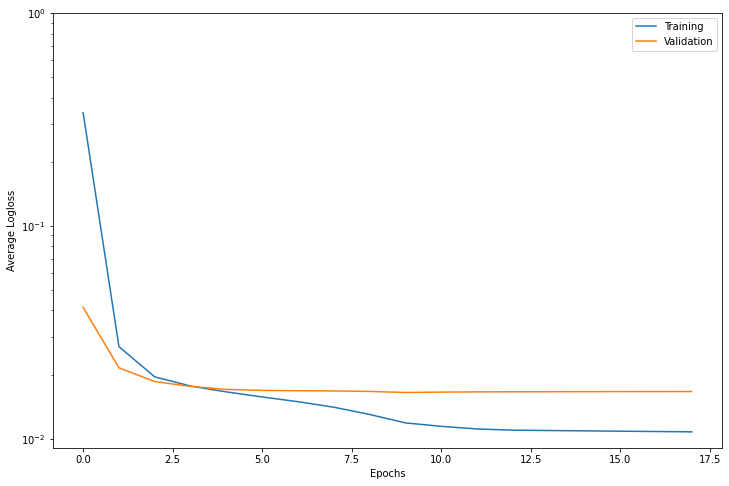

In [ ]:
# Analysis of Training

tf.print('OOF score is ',oof)

plt.figure(figsize=(12,8))

hist_trains = []
hist_lens = []
for i in range(n_folds*n_seeds):
    hist_train = (hists[i]).history['logloss']
    hist_trains.append(hist_train)
    hist_lens.append(len(hist_train))
hist_train = []
for i in range(min(hist_lens)):
    hist_train.append(np.mean([hist_trains[j][i] for j in range(n_folds*n_seeds)]))

plt.plot(hist_train)

hist_vals = []
hist_lens = []
for i in range(n_folds*n_seeds):
    hist_val = (hists[i]).history['val_logloss']
    hist_vals.append(hist_val)
    hist_lens.append(len(hist_val))
hist_val = []
for i in range(min(hist_lens)):
    hist_val.append(np.mean([hist_vals[j][i] for j in range(n_folds*n_seeds)]))

plt.plot(hist_val)

plt.yscale('log')
plt.yticks(ticks=[1,1E-1,1E-2])
plt.xlabel('Epochs')
plt.ylabel('Average Logloss')
plt.legend(['Training','Validation'])

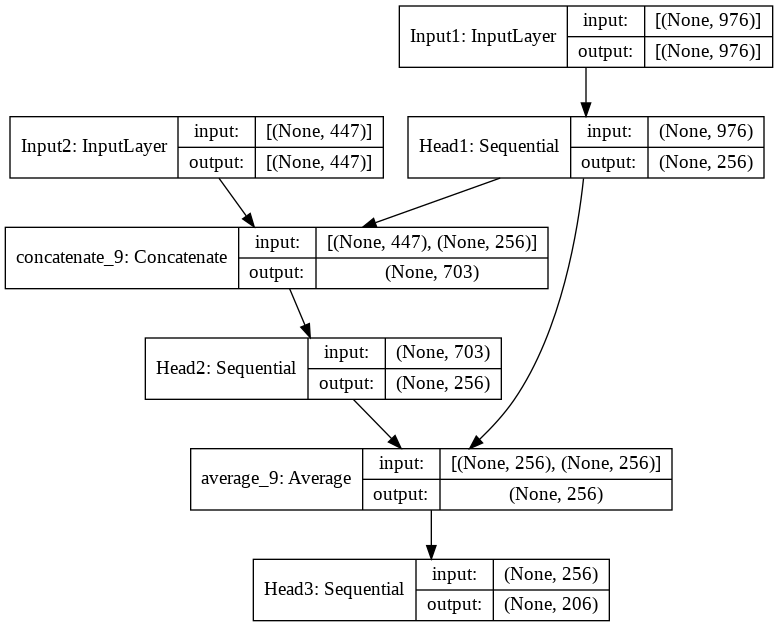

In [ ]:
# Model Architecture
tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
X_train, X_test = preprocessor(train_features.iloc[train].values,
                                       train_features.iloc[test].values)